### Prepare ResNet-50

In [6]:
import torch
import numpy as np
from PIL import Image
from urllib.request import urlopen
from transformers import AutoImageProcessor, ResNetForImageClassification


class HuggingFaceModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        logits = outputs.logits.to(dtype=torch.double)
        return logits

class DoubleModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model.to(dtype=torch.double)

    def forward(self, x):
        x = x.to(dtype=torch.double)
        outputs = self.model(x)
        logits = outputs.logits.to(dtype=torch.double)
        return logits

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
hf_resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
resnet = HuggingFaceModelWrapper(hf_resnet)


### Load Test Image

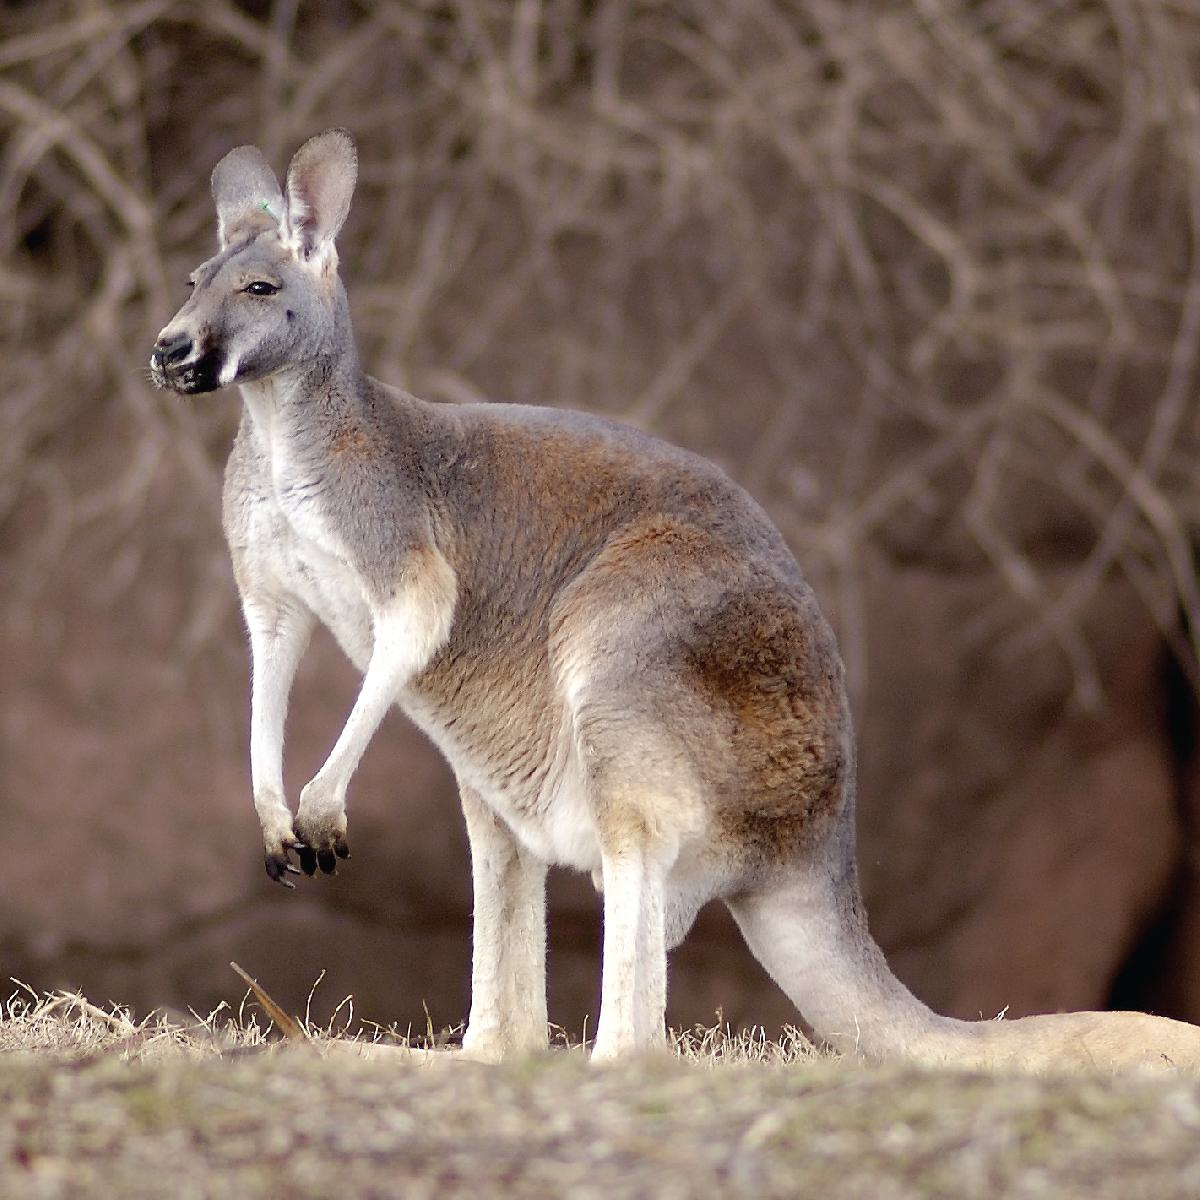

In [7]:
test_image = Image.open(urlopen("https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d"))
display(test_image)

Resnet50 has input shape of (224, 224, 3), therefore we need to preprocess image first.

In [8]:
#using previously defined processor
inputs = processor(test_image, return_tensors="pt")

with torch.no_grad():
    logits = hf_resnet(**inputs).logits

pred_label = logits.argmax(-1).item()
print(hf_resnet.config.id2label[pred_label])

wallaby, brush kangaroo


## Targeted Attacks:

In [9]:
# art requires to create a classifier for the model first
from art.estimators.classification import PyTorchClassifier

resnet_classifier = PyTorchClassifier(
    model=resnet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=(3,224,224),
    nb_classes=hf_resnet.config.num_labels,
    clip_values=(0,1)
)

ResNet-50 was trained on [ImageNet-1k](https://huggingface.co/datasets/ILSVRC/imagenet-1k) dataset

Below are all classes for this dataset:

In [10]:
class_names = hf_resnet.config.id2label

for class_id, class_name in class_names.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Class ID: 0, Class Name: tench, Tinca tinca
Class ID: 1, Class Name: goldfish, Carassius auratus
Class ID: 2, Class Name: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
Class ID: 3, Class Name: tiger shark, Galeocerdo cuvieri
Class ID: 4, Class Name: hammerhead, hammerhead shark
Class ID: 5, Class Name: electric ray, crampfish, numbfish, torpedo
Class ID: 6, Class Name: stingray
Class ID: 7, Class Name: cock
Class ID: 8, Class Name: hen
Class ID: 9, Class Name: ostrich, Struthio camelus
Class ID: 10, Class Name: brambling, Fringilla montifringilla
Class ID: 11, Class Name: goldfinch, Carduelis carduelis
Class ID: 12, Class Name: house finch, linnet, Carpodacus mexicanus
Class ID: 13, Class Name: junco, snowbird
Class ID: 14, Class Name: indigo bunting, indigo finch, indigo bird, Passerina cyanea
Class ID: 15, Class Name: robin, American robin, Turdus migratorius
Class ID: 16, Class Name: bulbul
Class ID: 17, Class Name: jay
Class ID: 18, Class Name:

### Performing Carlini-Wagner L2 attack

In [11]:
# for some reason this attack refuses to work, need to fix later
# UPDATE: Fixed method, learning rate for resnet50 needs to be HIGHER than expected

from art.attacks.evasion import CarliniL2Method
import torchvision as tvision
import numpy as np

# img = inputs["pixel_values"].numpy()

resnet_carlini = DoubleModelWrapper(hf_resnet)

resnet_classifier = PyTorchClassifier(
    model=resnet_carlini,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    input_shape=(3,224,224),
    nb_classes=hf_resnet.config.num_labels,
    clip_values=(0,1)
)

img_transforms = tvision.transforms.Compose([
    tvision.transforms.Resize((224, 224)),  
    tvision.transforms.ToTensor(),
])

img = img_transforms(test_image).unsqueeze(0).numpy()

attack = CarliniL2Method(classifier=resnet_classifier, targeted=True, max_iter=10, learning_rate=0.1)

# Targeted class in this case is a broom, that has id of 462
targets = np.zeros((1, hf_resnet.config.num_labels))
targets[0, 462] = 1

adv_img = attack.generate(x=img, y=targets)

normal_pred = resnet_classifier.predict(img)
adv_pred = resnet_classifier.predict(adv_img)


C&W L_2:   0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [76]:
# helper function to convert classifier output to label
def convert2label(pred):
    temp_tensor = torch.from_numpy(pred)
    label_id = int(torch.argmax(temp_tensor))
    return hf_resnet.config.id2label[label_id]

diff = np.abs(adv_img - img)
print("Maximum pixel difference:", diff.max())
print("Mean pixel difference:", diff.mean())
print(f"Normal prediction: {convert2label(normal_pred)}")
print(f"Adversarial prediction: {convert2label(adv_pred)}")

Maximum pixel difference: 0.0
Mean pixel difference: 0.0
Normal prediction: wallaby, brush kangaroo
Adversarial prediction: wallaby, brush kangaroo


In [16]:
from art.attacks.evasion import ProjectedGradientDescent

img_transforms = tvision.transforms.Compose([
    tvision.transforms.Resize((224, 224)),  
    tvision.transforms.ToTensor(),
])

img = img_transforms(test_image).unsqueeze(0).numpy()

attack = ProjectedGradientDescent(resnet_classifier, norm = np.inf, targeted=True)

# img = inputs["pixel_values"].numpy()

# Targeted class in this case is a broom, that has id of 462
targets = np.zeros((1, hf_resnet.config.num_labels))
targets[0, 462] = 1


adv_img = attack.generate(x=img, y=targets)

normal_pred = resnet_classifier.predict(img)
adv_pred = resnet_classifier.predict(adv_img)

KeyboardInterrupt: 

In [ ]:
print(f"Normal prediction: {convert2label(normal_pred)}")
print(f"Adversarial prediction: {convert2label(adv_pred)}")

Normal prediction: wallaby, brush kangaroo
Adversarial prediction: broom


## Undirected Attack

#### Elastic Net (EADEN)

In [9]:
from art.attacks.evasion import ElasticNet

attack = ElasticNet(classifier=resnet_classifier, confidence=0.0, targeted=False)

adv_img = attack.generate(x=img)

normal_pred = resnet_classifier.predict(img)
adv_pred = resnet_classifier.predict(adv_img)

EAD: 100%|██████████| 1/1 [05:39<00:00, 339.87s/it]


In [10]:
print(f"Normal prediction: {convert2label(normal_pred)}")
print(f"Adversarial prediction: {convert2label(adv_pred)}")

Normal prediction: wallaby, brush kangaroo
Adversarial prediction: Irish terrier


#### Deep Fool

In [11]:
from art.attacks.evasion import DeepFool

attack = DeepFool(classifier=resnet_classifier)

adv_img = attack.generate(x=img)

normal_pred = resnet_classifier.predict(img)
adv_pred = resnet_classifier.predict(adv_img)

DeepFool: 100%|██████████| 1/1 [01:05<00:00, 65.92s/it]


In [12]:
print(f"Normal prediction: {convert2label(normal_pred)}")
print(f"Adversarial prediction: {convert2label(adv_pred)}")

Normal prediction: wallaby, brush kangaroo
Adversarial prediction: timber wolf, grey wolf, gray wolf, Canis lupus


#### Virtual Adversarial Method

Virtual Adversarial Method took way too long to complete (nearly two hours, when I stopped execution and it was still far from done), so we swapped it for a HopSkipJumpAttack instead

In [13]:
# class VAMModelWrapper(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, x):
#         logits = self.model(x).logits
#         return torch.nn.functional.softmax(logits, dim=1)

In [14]:
# resnet_vam = VAMModelWrapper(hf_resnet)

# resnet_vam_classifier = PyTorchClassifier(
#     model=resnet_vam,
#     loss=torch.nn.CrossEntropyLoss(),
#     optimizer=None,
#     input_shape=(3,224,224),
#     nb_classes=hf_resnet.config.num_labels,
#     clip_values=(0,1)
# )

In [ ]:
resnet_hop = DoubleModelWrapper(hf_resnet)

resnet_hop_classifier = PyTorchClassifier(
    model=resnet_hop,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=None,
    input_shape=(3,224,224),
    nb_classes=hf_resnet.config.num_labels,
    clip_values=(0,1)
)

In [16]:
from art.attacks.evasion import HopSkipJump

attack = HopSkipJump(classifier=resnet_hop_classifier, norm=2, max_iter=10)

img = img.astype(np.double)
adv_img = attack.generate(x=img)
adv_img = adv_img.astype(np.double)

normal_pred = resnet_classifier.predict(img)
adv_pred = resnet_classifier.predict(adv_img)

HopSkipJump: 100%|██████████| 1/1 [03:59<00:00, 239.73s/it]


In [17]:
print(f"Normal prediction: {convert2label(normal_pred)}")
print(f"Adversarial prediction: {convert2label(adv_pred)}")

Normal prediction: wallaby, brush kangaroo
Adversarial prediction: kit fox, Vulpes macrotis


In [45]:
#testing if carlini wagner will work on diffrent model
import timm
import requests

model_mobile = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
model_mobile = model_mobile.eval()

data_config = timm.data.resolve_model_data_config(model_mobile)
transforms = timm.data.create_transform(**data_config, is_training=False)



url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(url).json()
display(imagenet_labels)

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [46]:
image_tensor = transforms(test_image).unsqueeze(0)

with torch.no_grad():
    logits = model_mobile(image_tensor)
probabilities = torch.nn.functional.softmax(logits, dim=-1)

pred_label_idx = torch.argmax(probabilities).item()
pred_label_name = imagenet_labels[pred_label_idx]

print(f"Predicted class name: {pred_label_name} (ID: {pred_label_idx} with certainty: {torch.max(probabilities).item()})")

Predicted class name: wallaby (ID: 104 with certainty: 0.9347825646400452)


In [59]:
mobile_classifier=PyTorchClassifier(
    model=model_mobile,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    input_shape=(3,224,224),
    nb_classes=len(imagenet_labels),
    clip_values=(0,1)
)

In [63]:
attack = CarliniL2Method(classifier=mobile_classifier, targeted=True)

# Targeted class in this case is a broom, that has id of 462
targets = np.zeros((1, hf_resnet.config.num_labels))
targets[0, 462] = 1

adv_img = attack.generate(x=img, y=targets)

normal_pred = mobile_classifier.predict(img)
adv_pred = mobile_classifier.predict(adv_img)


C&W L_2: 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]


In [64]:
print(f"Normal prediction: {convert2label(normal_pred)}")
print(f"Adversarial prediction: {convert2label(adv_pred)}")

Normal prediction: wallaby, brush kangaroo
Adversarial prediction: broom


## Method works, maybe needs more time for Resnet50
